<a href="https://colab.research.google.com/github/ZenithSun/citibike_case_study/blob/main/Citibike_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
# !pip install keplergl

In [1]:
!pip install prophet

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import folium
from folium.plugins import HeatMap, HeatMapWithTime
from IPython.display import display, HTML
from scipy.stats import percentileofscore
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
# import requests

# Ignore all warnings
warnings.filterwarnings('ignore')
# Adjust display options for pandas
pd.set_option('display.max_columns', None)  # Show all columns
# Setting a professional style
sns.set_theme(style="dark")

In [3]:
from google.colab import output
output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# **1. EDA**

In [ ]:
'''
1. Find and remove anomalies (age, starttime > endtime, too long duration >24h, )
2. density based heatmap by hour of the day, year etc
3. analyze the seasonality and trend and make prediction of usage
4. clustering?
5. recommendation and promotions based on the clusters
'''

## **1.1 Import Data**

In [4]:
def describe_data(df):
    summary = {}

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):  # Continuous variables
            summary[col] = {
                'Type': 'Continuous',
                'Count': df[col].count(),
                'Mean': df[col].mean(),
                'Median': df[col].median(),
                'Std': df[col].std(),
                'Min': df[col].min(),
                '25%': df[col].quantile(0.25),
                '50%': df[col].quantile(0.50),
                '75%': df[col].quantile(0.75),
                'Max': df[col].max(),
            }
        elif pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:  # Categorical variables
            summary[col] = {
                'Type': 'Categorical',
                'Count': df[col].count(),
                'Unique': df[col].nunique(),
                'Top': df[col].mode()[0] if not df[col].mode().empty else None,
                'Freq': df[col].value_counts().iloc[0] if not df[col].value_counts().empty else None
            }

    return pd.DataFrame(summary).T

### **1.1.1 Load citibike trip sample**

In [5]:
citibike_trip_sample_df = pd.read_csv('citibike-trips-sample.csv')
citibike_trip_sample_df['starttime'] = pd.to_datetime(citibike_trip_sample_df['starttime'])
citibike_trip_sample_df['start_hour'] = citibike_trip_sample_df['starttime'].dt.hour
citibike_trip_sample_df['start_month'] = citibike_trip_sample_df['starttime'].dt.month
citibike_trip_sample_df['start_year'] = citibike_trip_sample_df['starttime'].dt.year

citibike_trip_sample_df['stoptime'] = pd.to_datetime(citibike_trip_sample_df['stoptime'])
citibike_trip_sample_df['stop_hour'] = citibike_trip_sample_df['stoptime'].dt.hour
citibike_trip_sample_df['stop_month'] = citibike_trip_sample_df['stoptime'].dt.month
citibike_trip_sample_df['stop_year'] = citibike_trip_sample_df['stoptime'].dt.year
citibike_trip_sample_df[['start_station_id', 'end_station_id']] = citibike_trip_sample_df[['start_station_id', 'end_station_id']].astype(str)
citibike_trip_sample_df['user_age'] = citibike_trip_sample_df['start_year'] - citibike_trip_sample_df['birth_year']
citibike_trip_sample_df.shape

(315785, 23)

In [6]:
# Check the time range of the trip sample data
print("Start Time Range: {} to {}".format(citibike_trip_sample_df.starttime.min(), citibike_trip_sample_df.starttime.max()))
print("Stop Time Range: {} to {}".format(citibike_trip_sample_df.stoptime.min(), citibike_trip_sample_df.stoptime.max()))

Start Time Range: 2013-07-01 00:02:00 to 2016-08-30 23:33:00
Stop Time Range: 2013-07-01 00:12:00 to 2016-08-30 23:50:00


In [7]:
citibike_trip_sample_df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,start_hour,start_month,start_year,stop_hour,stop_month,stop_year,user_age
0,2319,2016-03-09 13:08:00,2016-03-09 13:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,363,West Thames St,40.708347,-74.017134,23062,Subscriber,1972.0,male,NaN,13,3,2016,13,3,2016,44.0
1,313,2015-07-09 15:42:00,2015-07-09 15:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,493,W 45 St & 6 Ave,40.756800,-73.982912,16909,Subscriber,1968.0,female,NaN,15,7,2015,15,7,2015,47.0
2,906,2016-01-11 18:32:00,2016-01-11 18:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3162,W 78 St & Broadway,40.783400,-73.980931,15614,Subscriber,1961.0,male,NaN,18,1,2016,18,1,2016,55.0
3,716,2013-10-30 11:53:00,2013-10-30 12:05:00,520,W 52 St & 5 Ave,40.759923,-73.976485,533,Broadway & W 39 St,40.752996,-73.987216,19280,Subscriber,1954.0,male,NaN,11,10,2013,12,10,2013,59.0
4,312,2014-06-04 16:12:00,2014-06-04 16:17:00,520,W 52 St & 5 Ave,40.759923,-73.976485,519,E 42 St & Vanderbilt Ave,40.752416,-73.978370,16483,Subscriber,1963.0,male,NaN,16,6,2014,16,6,2014,51.0


In [8]:
describe_data(citibike_trip_sample_df)

,Type,Count,Mean,Median,Std,Min,25%,50%,75%,Max,Unique,Top,Freq
tripduration,Continuous,315785,938.498763,631.0,6534.949983,60,391.0,631.0,1051.0,1733173,NaN,NaN,NaN
start_station_id,Categorical,315785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,575,519,3374
start_station_name,Categorical,315785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599,8 Ave & W 31 St,2812
start_station_latitude,Continuous,315785,40.735735,40.736529,0.020822,40.646678,40.721101,40.736529,40.750977,40.804213,NaN,NaN,NaN
start_station_longitude,Continuous,315785,-73.989392,-73.990093,0.014088,-74.017134,-73.999318,-73.990093,-73.981281,-73.929891,NaN,NaN,NaN
end_station_id,Categorical,315785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,584,519,3028
end_station_name,Categorical,315785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,607,E 17 St & Broadway,3012
end_station_latitude,Continuous,315785,40.735366,40.736502,0.075412,0.0,40.720874,40.736502,40.750664,40.804213,NaN,NaN,NaN
end_station_longitude,Continuous,315785,-73.989326,-73.990214,0.13242,-74.017134,-73.999744,-73.990214,-73.981346,0.0,NaN,NaN,NaN
bikeid,Continuous,315785,19074.89687,18779.0,2888.180823,14529,16687.0,18779.0,21090.0,26884,NaN,NaN,NaN


### **1.1.1 Load citibike stations data**

In [9]:
citibike_station_df = pd.read_csv('citibike-stations.csv')
citibike_station_df[['station_id_int', 'region_id', 'eightd_has_key_dispenser', 'is_installed', 'is_renting', 'is_returning', 'eightd_has_available_keys']] = citibike_station_df[['station_id_int', 'region_id', 'eightd_has_key_dispenser', 'is_installed', 'is_renting', 'is_returning', 'eightd_has_available_keys']].astype(str)
citibike_station_df.shape

(1802, 17)

In [10]:
citibike_station_df.head()

,station_id_int,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys
0,3664,North Moore St & Greenwich St,5470.12,40.720195,-74.010301,71,"KEY, CREDITCARD",29,False,2,1,0,29,True,True,True,False
1,4682,W 34 St & Hudson Blvd E,6535.04,40.755167,-74.000599,71,"KEY, CREDITCARD",57,False,2,1,52,2,True,True,True,False
2,3233,E 48 St & 5 Ave,6626.01,40.757246,-73.978059,71,"KEY, CREDITCARD",62,False,2,1,43,14,True,True,True,False
3,244,Willoughby Ave & Hall St,4611.03,40.691960,-73.965369,71,"KEY, CREDITCARD",51,False,12,1,32,6,True,True,True,False
4,525,W 34 St & 11 Ave,6578.01,40.755942,-74.002116,71,"KEY, CREDITCARD",80,False,35,1,22,19,True,True,True,False


In [11]:
describe_data(citibike_station_df)

,Type,Count,Unique,Top,Freq,Mean,Median,Std,Min,25%,50%,75%,Max
station_id_int,Categorical,1802,1802,116,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,Categorical,1802,1802,1 Ave & E 110 St,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
short_name,Categorical,1802,1802,2733.03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,Continuous,1802,NaN,NaN,NaN,40.723477,40.740629,0.961808,0.0,40.696093,40.740629,40.793693,40.88226
longitude,Continuous,1802,NaN,NaN,NaN,-73.909348,-73.947438,1.742434,-74.03281,-73.982605,-73.947438,-73.918636,0.0
region_id,Categorical,1802,3,71,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rental_methods,Categorical,1802,1,"KEY, CREDITCARD",1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capacity,Continuous,1802,NaN,NaN,NaN,30.95616,25.0,17.046749,0,21.0,25.0,37.0,123
eightd_has_key_dispenser,Categorical,1802,1,False,1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_bikes_available,Continuous,1802,NaN,NaN,NaN,11.933962,7.0,13.884131,0,2.0,7.0,18.0,80


## **1.2 Explore Data Distributions and Identify Potential Outliers/Anomalies**

## **1.2.1 Start Time and Stop Time**

In [12]:
# Find out start time is later than stop time
# citibike_trip_sample_df.query('starttime>=stoptime').shape
citibike_trip_sample_df.query('starttime>=stoptime')

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,start_hour,start_month,start_year,stop_hour,stop_month,stop_year,user_age
18683,633,2015-11-01 01:50:00,2015-11-01 01:01:00,401,Allen St & Rivington St,40.720196,-73.989978,527,E 33 St & 2 Ave,40.744023,-73.976056,22787,Subscriber,1988.0,male,NaN,1,11,2015,1,11,2015,27.0


* There is one record where stoptime is earlier than startime. This is a clear anomalous data point that might be caused by entry error.

## **1.2.2 User Age**

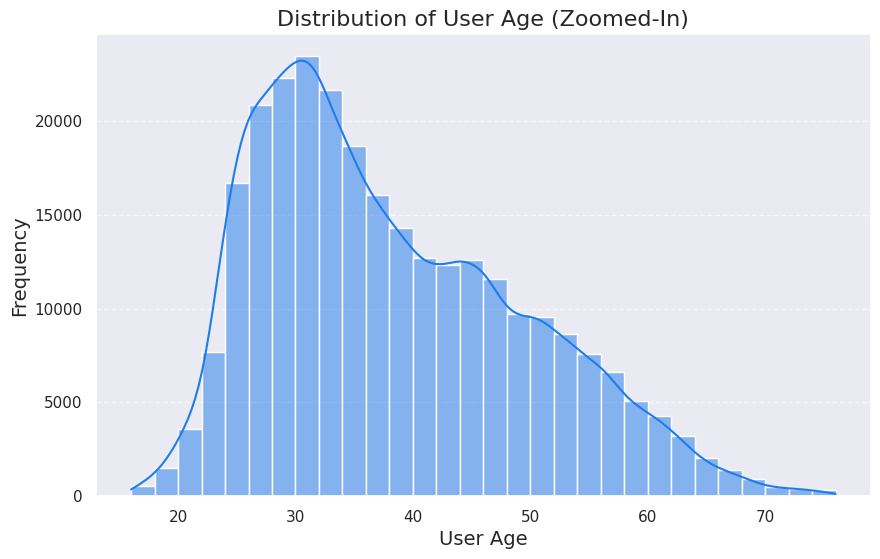

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(citibike_trip_sample_df[citibike_trip_sample_df['user_age'] <
                                     citibike_trip_sample_df['user_age'].quantile(0.999)],
             x='user_age', kde=True, color='#1f7ced', bins=30)
plt.title('Distribution of User Age (Zoomed-In)', fontsize=16)
plt.xlabel('User Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
citibike_trip_sample_df['user_age'].quantile(0.99), citibike_trip_sample_df['user_age'].quantile(0.999)

(67.0, 76.10700000001816)

In [15]:
print(citibike_trip_sample_df.query('user_age>=76').shape)
citibike_trip_sample_df.query('user_age>=76').head()

(339, 23)


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,start_hour,start_month,start_year,stop_hour,stop_month,stop_year,user_age
1636,1305,2014-10-18 08:25:00,2014-10-18 08:47:00,349,Rivington St & Ridge St,40.718502,-73.983299,467,Dean St & 4 Ave,40.683125,-73.978951,17955,Subscriber,1910.0,male,NaN,8,10,2014,8,10,2014,104.0
3121,286,2016-07-28 18:41:00,2016-07-28 18:46:00,395,Bond St & Schermerhorn St,40.688070,-73.984106,3246,Montague St & Clinton St,40.694281,-73.992300,25540,Subscriber,1940.0,male,NaN,18,7,2016,18,7,2016,76.0
3249,1411,2016-02-22 09:02:00,2016-02-22 09:25:00,446,W 24 St & 7 Ave,40.744876,-73.995299,475,E 16 St & Irving Pl,40.735243,-73.987586,22987,Subscriber,1940.0,female,NaN,9,2,2016,9,2,2016,76.0
5975,976,2016-01-11 16:29:00,2016-01-11 16:45:00,3141,1 Ave & E 68 St,40.765005,-73.958185,3171,Amsterdam Ave & W 82 St,40.785247,-73.976673,20933,Subscriber,1939.0,male,NaN,16,1,2016,16,1,2016,77.0
7346,2327,2014-11-10 13:37:00,2014-11-10 14:16:00,408,Market St & Cherry St,40.710762,-73.994004,302,Avenue D & E 3 St,40.720828,-73.977932,19900,Subscriber,1936.0,male,NaN,13,11,2014,14,11,2014,78.0


* The user age range that is below 99.9th percentile is between 16 and 76 years old. From statistical perspectives, any person whose age is above 76 years is considered as outliers and potential anomalies. But based on our experience, people in their 80s or even 90s, might still have the ability to ride bikes. Although it is not highly recommended. However, we do see some records in the table show the ages that are above 100. These are most likely the anomalies.
* Based on the distribution of user age, most of the citibike users are between 20 and 60 years old. This is aligh with our experience that most users are daily commuters in the city.
* **Potential TODO Actions**: If we do see significant increase of senior people using the citibike, more measures need to be taken to ensure their safety while riding。 Additionally, the user manual should be made more user-friendly.


## **1.2.3 Gender and User Type Distribution**

In [16]:
print(citibike_trip_sample_df.gender.value_counts())
print('----------------')
print(citibike_trip_sample_df.usertype.value_counts())

gender
male       211692
female      64887
unknown     39206
Name: count, dtype: int64
----------------
usertype
Subscriber    277448
Customer       38337
Name: count, dtype: int64


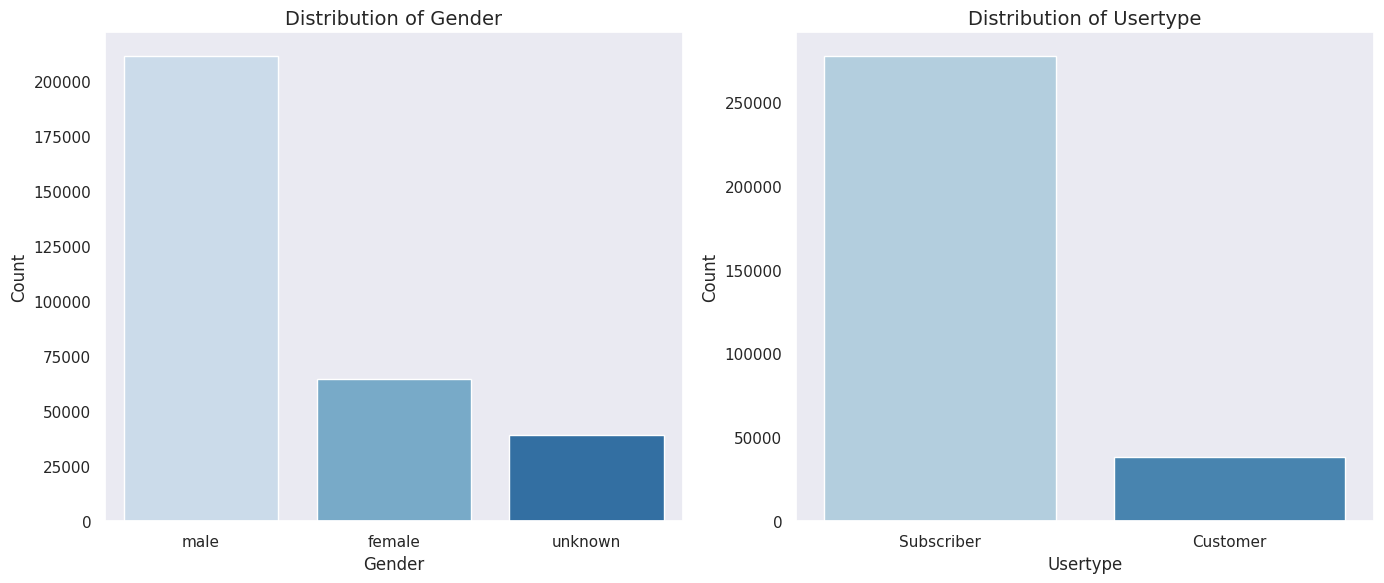

In [17]:
# Bar chart for categorical variables: gender and usertype
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Two charts side by side

# Bar chart for Gender
sns.countplot(data=citibike_trip_sample_df, x='gender', ax=axes[0], palette='Blues')
axes[0].set_title('Distribution of Gender', fontsize=14)
axes[0].set_xlabel('Gender', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Bar chart for Usertype
sns.countplot(data=citibike_trip_sample_df, x='usertype', ax=axes[1], palette='Blues')
axes[1].set_title('Distribution of Usertype', fontsize=14)
axes[1].set_xlabel('Usertype', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)


plt.tight_layout()



*   **Observation 1: The number of male users significantly exceeds that of female users**
  * The number of users from both genders should typically be similar. **This deviation from the norm is unusual.** If the data is accurate, it suggests there may be factors discouraging female users from utilizing Citibike.
  * There is one of the articles explained the potential reasons why females don't like riding Citi Bikes. ["Why Aren’t More Women Riding Citi Bikes?"](https://www.thecut.com/2015/07why-arent-more-women-riding-citi-bikes.html)
      -  Safety Concerns: Women often feel less safe navigating city traffic on bicycles, which can discourage them from using bike-sharing services.

      -  Convenience Issues: The design of Citi Bikes and the docking stations may not accommodate women's clothing choices, such as skirts or dresses, making the service less convenient for them.

      - Maintenance and Cleanliness: Women may be more sensitive to the cleanliness and maintenance of shared bikes, and any deficiencies in these areas can be a deterrent.

      - Marketing and Outreach: The marketing strategies of bike-sharing programs may not effectively target women, leading to lower awareness and usage among this demographic.

*   **Observation 2: Subscribers make up the majority of the overall user base**
  * Convenience and Accessibility: Annual members have 24/7 access to thousands of bikes across multiple boroughs, providing a reliable transportation alternative to subways, taxis, and buses.

  * This also leads to another **DISCUSSION**: Whether Citi Bike wants more customers who purchase 24-hour pass or 7-day pass. According to the pricing plan, the more customers will bring more profit. On the other hand, this might lower the bike availability for subscribers who have the annual membership.





## **1.2.4 Trip Duration**

In [18]:
# Check the quantile and percentile of the trip duration
q1 = citibike_trip_sample_df['tripduration'].quantile(0.01)
q99 = citibike_trip_sample_df['tripduration'].quantile(0.99)
percentile_24hr = percentileofscore(citibike_trip_sample_df['tripduration'], 24*60*60, kind='rank') / 100

# Printing the information
print(f"1st Percentile (0.01 Quantile) of 'tripduration': {q1}")
print(f"99th Percentile (0.99 Quantile) of 'tripduration': {q99}")
print(f"Percentile rank of 24 hours (in seconds) for 'tripduration': {percentile_24hr:.4f}")

1st Percentile (0.01 Quantile) of 'tripduration': 119.0
99th Percentile (0.99 Quantile) of 'tripduration': 3879.0
Percentile rank of 24 hours (in seconds) for 'tripduration': 0.9998


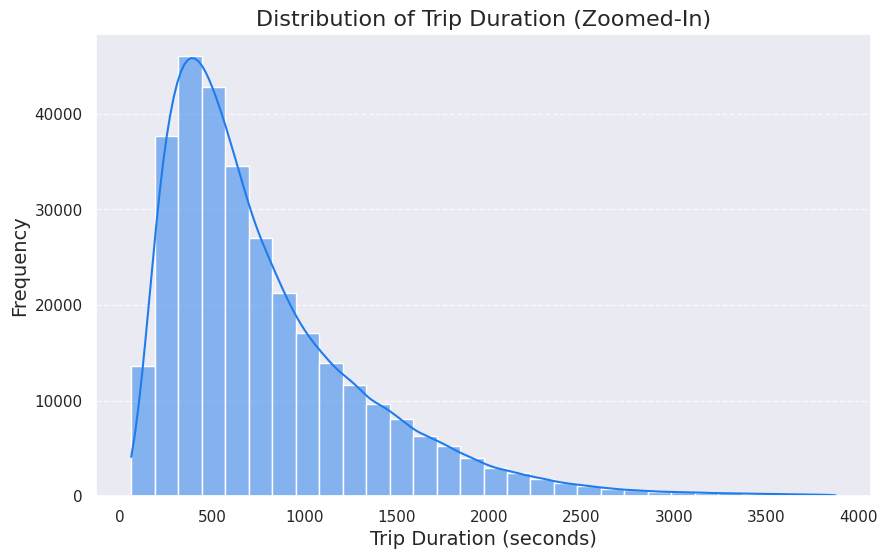

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(citibike_trip_sample_df[citibike_trip_sample_df['tripduration'] <
                                     citibike_trip_sample_df['tripduration'].quantile(0.99)],
             x='tripduration', kde=True, color='#1f7ced', bins=30)
plt.title('Distribution of Trip Duration (Zoomed-In)', fontsize=16)
plt.xlabel('Trip Duration (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# # Boxplot to Highlight Outliers
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=citibike_trip_sample_df, y='tripduration', color='skyblue')
# plt.title('Boxplot of Trip Duration', fontsize=16)
# plt.ylabel('Trip Duration (seconds)', fontsize=14)
# plt.ylim(0, citibike_trip_sample_df['tripduration'].quantile(0.99))  # Focus on 99th percentile
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

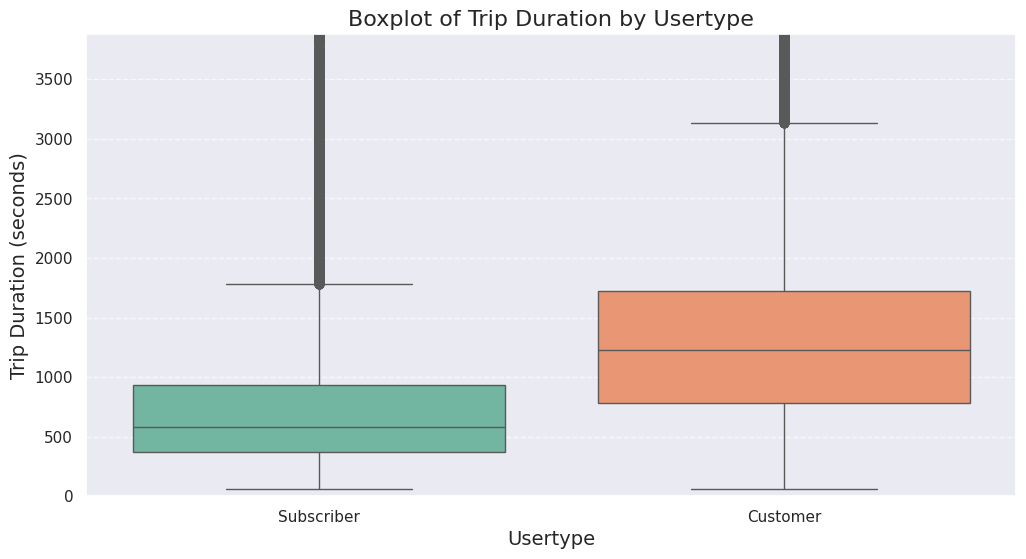

In [20]:
# Boxplot by Usertype
plt.figure(figsize=(12, 6))
sns.boxplot(data=citibike_trip_sample_df, x='usertype', y='tripduration', color='skyblue', palette='Set2')
plt.title('Boxplot of Trip Duration by Usertype', fontsize=16)
plt.xlabel('Usertype', fontsize=14)
plt.ylabel('Trip Duration (seconds)', fontsize=14)
plt.ylim(0, citibike_trip_sample_df['tripduration'].quantile(0.99))  # Focus on 99th percentile
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

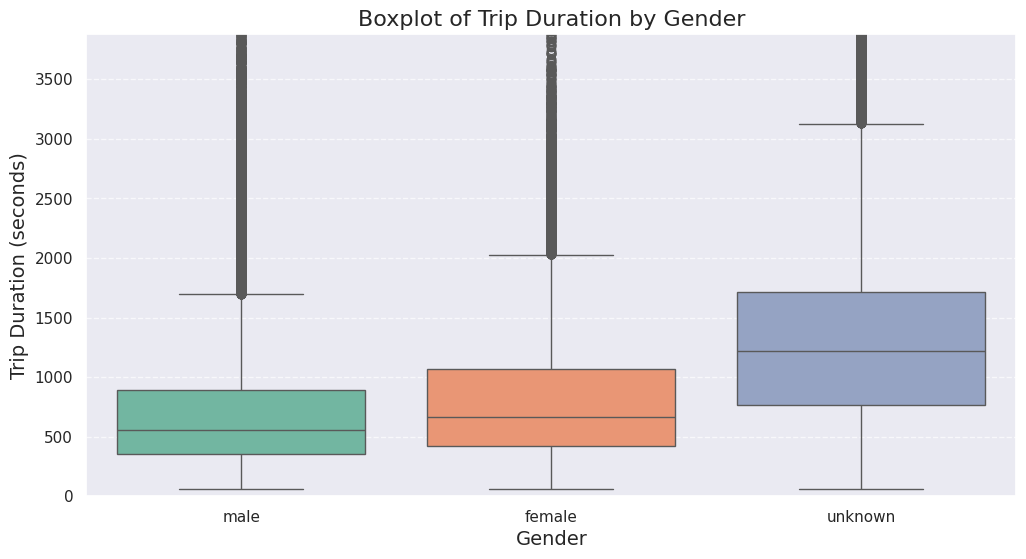

In [21]:
# Boxplot by Gender
plt.figure(figsize=(12, 6))
sns.boxplot(data=citibike_trip_sample_df, x='gender', y='tripduration', color='skyblue', palette='Set2')
plt.title('Boxplot of Trip Duration by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Trip Duration (seconds)', fontsize=14)
plt.ylim(0, citibike_trip_sample_df['tripduration'].quantile(0.99))  # Focus on 99th percentile
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# # Distribution plot for Tripduration
# plt.figure(figsize=(10, 6))
# sns.histplot(data=citibike_trip_sample_df, x='tripduration', kde=True, color='Purple', bins=300)
# plt.title('Distribution of Trip Duration', fontsize=16)
# plt.xlabel('Trip Duration (seconds)', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.show()

In [22]:
trip_start_hour_map_data = citibike_trip_sample_df.groupby(['start_station_name', 'start_station_latitude', 'start_station_longitude', 'start_hour']).size().reset_index(name='count')
trip_start_hour_map_data.columns = ['station_name', 'latitude', 'longitude', 'hour', 'count']
trip_end_hour_map_data = citibike_trip_sample_df.groupby(['end_station_name', 'end_station_latitude', 'end_station_longitude', 'stop_hour']).size().reset_index(name='count')
trip_end_hour_map_data.columns = ['station_name', 'latitude', 'longitude', 'hour', 'count']
trip_start_hour_map_data.shape, trip_end_hour_map_data.shape

((11536, 5), (11607, 5))

In [23]:
trip_start_month_map_data = citibike_trip_sample_df.groupby(['start_station_name', 'start_station_latitude', 'start_station_longitude', 'start_month']).size().reset_index(name='count')
trip_start_month_map_data.columns = ['station_name', 'latitude', 'longitude', 'month', 'count']
trip_end_month_map_data = citibike_trip_sample_df.groupby(['end_station_name', 'end_station_latitude', 'end_station_longitude', 'stop_month']).size().reset_index(name='count')
trip_end_month_map_data.columns = ['station_name', 'latitude', 'longitude', 'month', 'count']
trip_start_month_map_data.shape, trip_end_month_map_data.shape

((6052, 5), (6062, 5))

In [24]:
trip_start_hour_map_data.latitude.mean(), trip_start_hour_map_data.longitude.mean()

(40.73075455494539, -73.98023185396151)

In [ ]:
# trip_end_hour_map_data.head(10)

## **1.2.5 Geolocation Distribution of Citibike Station in Use Over Time**

In [25]:
def draw_heatmap(df):
  # Create a base map
  m = folium.Map(location=[40.73, -73.98], zoom_start=12, width=800, height=800)
  # Add heatmap to the map
  heat_data = [[row['latitude'], row['longitude'], row['count']] for index, row in df.iterrows()]
  HeatMap(heat_data, radius=15).add_to(m)
  return m

In [26]:
def draw_heatmap_with_time(df, timeframe_col = 'hour'):
    # Ensure 'hour' is sorted for proper time sequencing
    df = df.sort_values(by=timeframe_col)

    # Group data by hour and prepare heatmap data
    heat_data = []
    for hour, group in df.groupby(timeframe_col):
        heat_data.append(
            [[row['latitude'], row['longitude'], row['count']] for _, row in group.iterrows()]
        )

    # Create a base map
    m = folium.Map(location=[40.73, -73.98], zoom_start=12, width=800, height=800)

    # Add the HeatMapWithTime layer
    HeatMapWithTime(
        data=heat_data,
        radius=20,
        index=list(df[timeframe_col].unique()),  # Use unique 'hour' values as the time index
        auto_play=True,  # Automatically play through frames
        max_opacity=0.5,  # Reduce the opacity for a softer visual effect
        scale_radius=False,# Keep the radius consistent
        # scale_radius=True,
        #  gradient={0.1: 'blue', 0.3: 'cyan', 0.5: 'green', 0.75: 'yellow', 1: 'red'}

    ).add_to(m)

    return m


In [28]:
display(draw_heatmap_with_time(trip_start_hour_map_data, 'hour'))

In [ ]:
display(draw_heatmap_with_time(trip_end_hour_map_data, 'hour'))

In [ ]:
display(draw_heatmap_with_time(trip_start_month_map_data, 'month'))

In [ ]:
display(draw_heatmap_with_time(trip_end_month_map_data, 'month'))

## **2. Citibike Usage Forecast**

## **2.1 Remove Outliers**

In [27]:
# Remove outliers
citibike_trip_sample_clean_df = citibike_trip_sample_df.copy()
print(citibike_trip_sample_df.shape)
citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('starttime<stoptime')
print(citibike_trip_sample_clean_df.shape)
citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('tripduration < 24*60*60')
print(citibike_trip_sample_clean_df.shape)
## Most customers don't put birth year when rent a bike. And this is not the most essential info when it comes to usage forecast
# citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('user_age < 76')
# print(citibike_trip_sample_clean_df.shape)

(315785, 23)
(315784, 23)
(315712, 23)


In [28]:
citibike_trip_sample_df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,start_hour,start_month,start_year,stop_hour,stop_month,stop_year,user_age
0,2319,2016-03-09 13:08:00,2016-03-09 13:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,363,West Thames St,40.708347,-74.017134,23062,Subscriber,1972.0,male,NaN,13,3,2016,13,3,2016,44.0
1,313,2015-07-09 15:42:00,2015-07-09 15:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,493,W 45 St & 6 Ave,40.756800,-73.982912,16909,Subscriber,1968.0,female,NaN,15,7,2015,15,7,2015,47.0
2,906,2016-01-11 18:32:00,2016-01-11 18:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3162,W 78 St & Broadway,40.783400,-73.980931,15614,Subscriber,1961.0,male,NaN,18,1,2016,18,1,2016,55.0
3,716,2013-10-30 11:53:00,2013-10-30 12:05:00,520,W 52 St & 5 Ave,40.759923,-73.976485,533,Broadway & W 39 St,40.752996,-73.987216,19280,Subscriber,1954.0,male,NaN,11,10,2013,12,10,2013,59.0
4,312,2014-06-04 16:12:00,2014-06-04 16:17:00,520,W 52 St & 5 Ave,40.759923,-73.976485,519,E 42 St & Vanderbilt Ave,40.752416,-73.978370,16483,Subscriber,1963.0,male,NaN,16,6,2014,16,6,2014,51.0


## **2.2 Citibike Daily Usage Forecast with All Usertypes**
TODO:
1. Interpret the MAE and MSE
2. Explain the trend and seasonality
3. Other factors that may increase the accuracy: wheahter, safety, promotion
4. Prediction based on user type?

In [29]:
def usage_forecast(df):
  daily_trips = df.groupby(df['starttime'].dt.to_period('D')).size()
  daily_trips.index = daily_trips.index.to_timestamp()  # Convert to DatetimeIndex


  daily_trips = daily_trips.reset_index()
  # Ensure time series has a continuous index (fill missing days with 0 trips)
  # daily_trips = daily_trips.asfreq('D', fill_value=0)
  daily_trips.columns = ['ds', 'y']  # Rename columns for Prophet compatibility

  # Split data for training and testing
  train = daily_trips[(daily_trips['ds'] >= '2013-07-01') & (daily_trips['ds'] <= '2016-06-30')]
  test = daily_trips[(daily_trips['ds'] >= '2016-07-01') & (daily_trips['ds'] <= '2016-08-30')]

  # Initialize and train the Prophet model
  model = Prophet(interval_width=0.95) # Set to 95% confidence interval (default value is 80%)
  model.add_seasonality(name='weekly', period=7, fourier_order=3)
  model.add_seasonality(name='yearly', period=365.25, fourier_order=5)
  model.fit(train)

  # Make predictions for the test period
  future = model.make_future_dataframe(periods=365, freq='D')
  forecast = model.predict(future)

  # Extract predictions for the test period
  forecast_test = forecast[forecast['ds'].isin(test['ds'])]

  # Calculate evaluation metrics
  y_true = test['y'].values
  y_pred = forecast_test['yhat'].values

  # Mean Absolute Error (MAE)
  mae = mean_absolute_error(y_true, y_pred)

  # Mean Absolute Percentage Error (MAPE)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

  # Root Mean Squared Error (RMSE)
  rmse = mean_squared_error(y_true, y_pred, squared=False)

  # Root Mean Squared Percentage Error (RMSPE)
  rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100

  # Print metrics
  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
  print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
  print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe:.2f}%")

 # Create side-by-side plots
  fig, axes = plt.subplots(1, 2, figsize=(18, 6))

  # Full Forecast Plot
  axes[0].set_title('Prophet Forecast: Daily Trips')
  fig_full = model.plot(forecast, ax=axes[0])
  axes[0].scatter(test['ds'], test['y'], color='orange', label='Test Data', zorder=3, s=10)  # Add test data points
  axes[0].set_xlabel('Date')
  axes[0].set_ylabel('Number of Trips')
  axes[0].legend()

  # Zoomed-In Forecast Plot
  axes[1].set_title('Prophet Forecast: Zoomed-In for Last Two Months')
  fig_zoom = model.plot(forecast, ax=axes[1])
  axes[1].plot(
      test['ds'], test['y'],
      color='orange',
      label='Test Data (Line)',
      zorder=2,
      linestyle='-',
      marker='o',
      linewidth=1  # Adjust line thickness
  )
  axes[1].set_xlim(pd.Timestamp('2016-07-01'), pd.Timestamp('2016-08-30'))
  axes[1].set_xlabel('Date')
  axes[1].set_ylabel('Number of Trips')
  axes[1].legend()

  # Adjust layout
  plt.tight_layout()
  plt.show()

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpf38_k4/1iekawpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpf38_k4/zwjm7sv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13064', 'data', 'file=/tmp/tmpvpf38_k4/1iekawpa.json', 'init=/tmp/tmpvpf38_k4/zwjm7sv3.json', 'output', 'file=/tmp/tmpvpf38_k4/prophet_model8nrey2ut/prophet_model-20241203022302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:23:03 - cmdstanpy - INFO - Chain [1] done proc

Mean Absolute Error (MAE): 50.96
Mean Absolute Percentage Error (MAPE): 12.67%
Root Mean Squared Error (RMSE): 67.11
Root Mean Squared Percentage Error (RMSPE): 19.09%


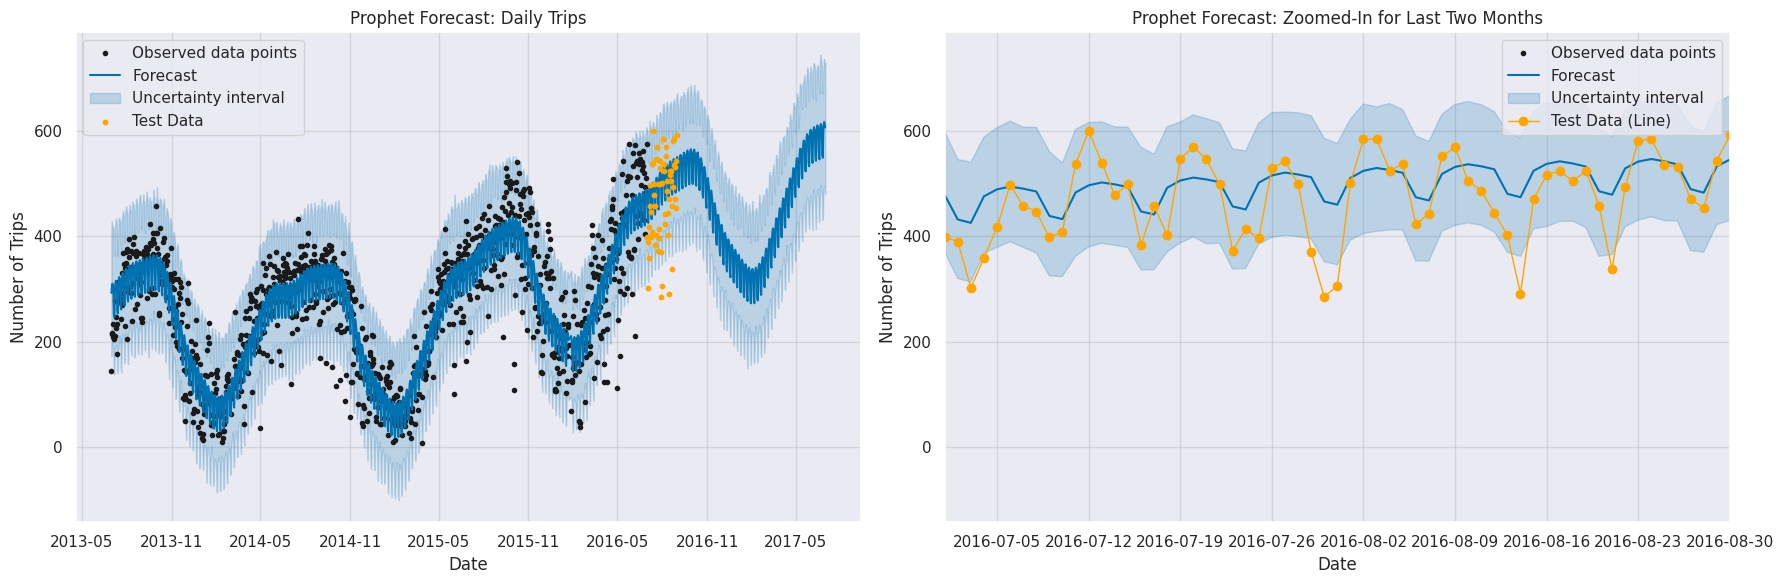

In [30]:
usage_forecast(citibike_trip_sample_clean_df)

In [31]:
# Aggregate daily data
subscriber_citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('usertype=="Subscriber"')
customer_citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('usertype=="Customer"')

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpf38_k4/uzqfkm_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpf38_k4/kqtz8zxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22243', 'data', 'file=/tmp/tmpvpf38_k4/uzqfkm_d.json', 'init=/tmp/tmpvpf38_k4/kqtz8zxl.json', 'output', 'file=/tmp/tmpvpf38_k4/prophet_modelsgkes0d_/prophet_model-20241203022306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:23:06 - cmdstanpy - INFO - Chain [1] done proc

Mean Absolute Error (MAE): 53.27
Mean Absolute Percentage Error (MAPE): 17.06%
Root Mean Squared Error (RMSE): 69.65
Root Mean Squared Percentage Error (RMSPE): 26.53%


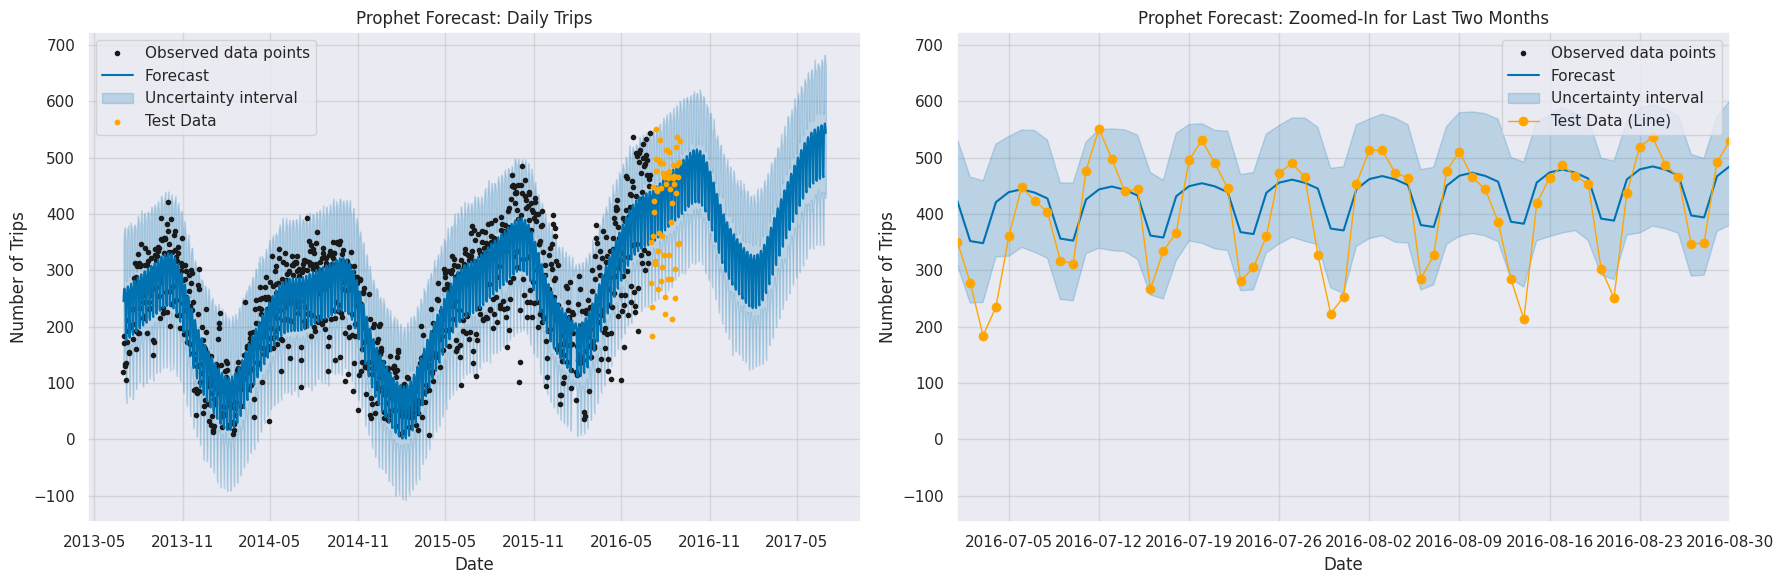

In [32]:
usage_forecast(subscriber_citibike_trip_sample_clean_df)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpf38_k4/7gf25q7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpf38_k4/c7nhtkki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69724', 'data', 'file=/tmp/tmpvpf38_k4/7gf25q7y.json', 'init=/tmp/tmpvpf38_k4/c7nhtkki.json', 'output', 'file=/tmp/tmpvpf38_k4/prophet_modelen59ljhi/prophet_model-20241203022313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:23:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:23:13 - cmdstanpy - INFO - Chain [1] done proc

Mean Absolute Error (MAE): 17.33
Mean Absolute Percentage Error (MAPE): 28.24%
Root Mean Squared Error (RMSE): 22.23
Root Mean Squared Percentage Error (RMSPE): 36.40%


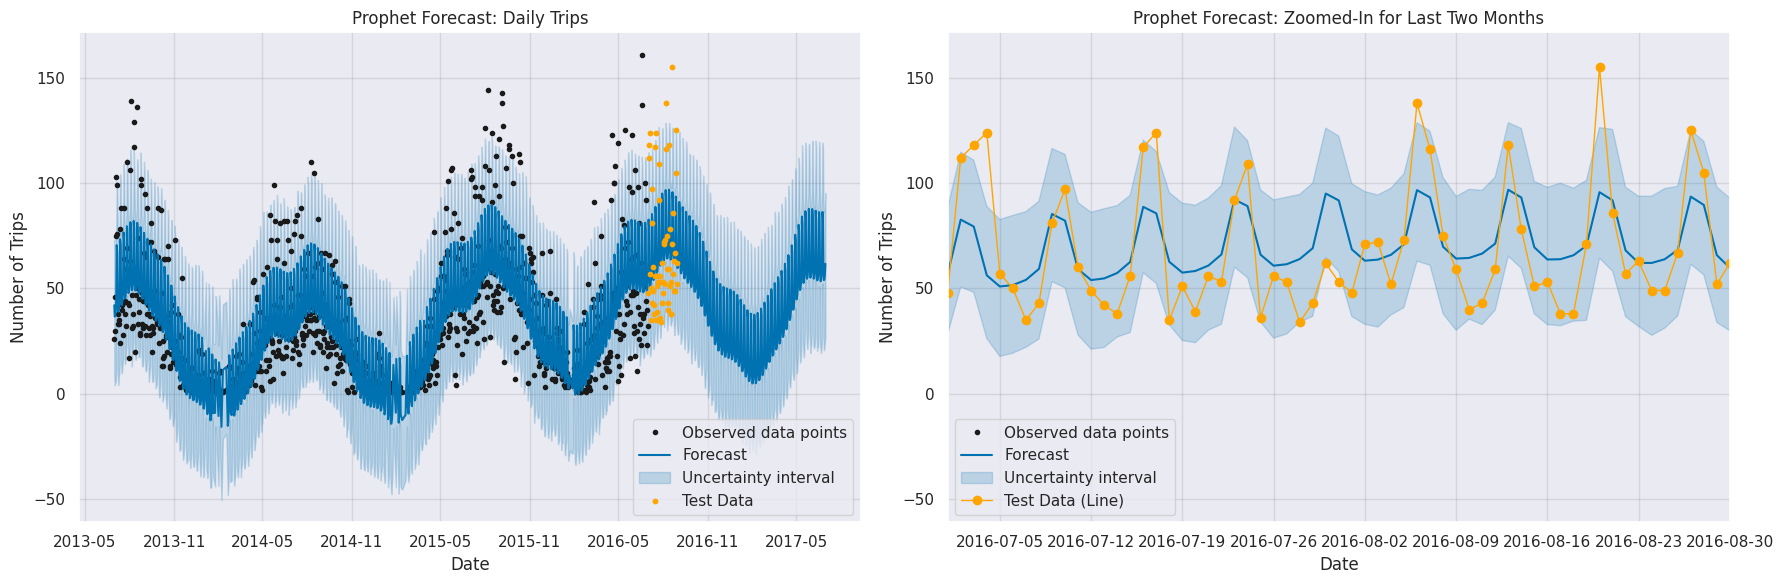

In [33]:
usage_forecast(customer_citibike_trip_sample_clean_df)

## **3. Bike Station Insights**

## **Others**

In [ ]:
!jupyter nbconvert --to html Citibike_Case_Study.ipynb


[NbConvertApp] Converting notebook Citibike_Case_Study.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 1666682 bytes to Citibike_Case_Study.html
